In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import time
import sys
import os
from multiprocessing import Pool
from functools import partial
directory = 'figures'
if not os.path.exists(directory):
    os.makedirs(directory)
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.notebook import tqdm
import numpy as np
from dask.distributed import Client, progress, LocalCluster
from dask import compute, delayed
import dask.array as da
from dask.diagnostics import ProgressBar
plt.rcParams['figure.dpi']=400

In [2]:
def denseH_MBL(L, J, hx_list, hz_list, periodic):
    """
    Generates the dense Hamiltonian matrix for the quantum Ising chain with both transverse and longitudinal magnetic fields
    
        Parameters:
            L (int): length of chain
            J (float): ising interaction strength
            hx (ndarray): array of transverse field strengths
            hz (ndarray): array of longitudinal field strengths
            periodic (bool): does the chain have periodic boundary conditions?
            
        Returns:
            H (ndarray): 2^L x 2^L matrix representing the Hamiltonian operator
    """

    dim=2 ** L # dimensions of the Hilbert space
    
    H = np.zeros((dim, dim), dtype = float) # initliaze the Hamiltonian
    
    "Calculation of off-diagonal elements due to the magnetic field"
    
    for beta in range(dim): # iterate over all states
        
        for j in range(1,L+1): # iterate over all sites
            
            alpha = beta ^ (1<<j-1) # flips jth bit of beta to get the state alpha that is related to beta by a single bit flip
            
            
            H[alpha, beta] -= hx_list[j-1] # contribution by sigma^j_x
            
            
            
    "Calculation of diagonal elements due to Ising interaction"

    for alpha in range(dim): # iterate over all states
        
        for j in range(1, L): # iterate over all sites
            
            if 2*(alpha & (1 << j-1)) == alpha & (1 << j): # check if site j and j+1 have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
            
        "Diagonal elements due to longitudinal magnetic field"
        
        for j in range(1, L+1):
            
            if alpha & (1 << (j-1)) == 0:  # check if the spin at site j is up
                H[alpha, alpha] -= hz_list[j-1]  # decrease energy for spin up
                
            else:
                H[alpha, alpha] += hz_list[j-1]  # increase energy for spin down

        
        "Handling case of periodic boundary conditions"
                
        if periodic and L > 1: # L > 1 needed for periodicity to mean anything
            
            if (alpha & (1 << L-1)) == ((alpha & (1 << 0))*(2**(L-1))): # Check if the states at either end have the same spin
                
                H[alpha, alpha] -= J # if they do, decrease the energy by the ising interaction term
                
            else:
                
                H[alpha, alpha] += J # if not, increase the energy by the ising interaction term
                
    return H   



def diagonalize_MBL(Ls, J, hx_list, hz_list, periodic):
    eigss = []
    vecss = []
    
    for i, L in enumerate(Ls):
        hx = hx_list[i]
        hz = hz_list[i]
        H = denseH_MBL(L, J, hx, hz, periodic)
        eigs, vecs = scipy.linalg.eigh(H)
        eigss.append(eigs)
        vecss.append(vecs)
    
    return eigss, vecss


In [11]:
Ls = [6, 8, 10, 12, 14]
J = 1
W = 3
periodic = True
num_realizations = 10

def generate_disorder(L, W):
    hx = np.random.uniform(-W, W, L)
    hz = np.random.uniform(-W, W, L)
    return hx, hz

In [12]:
all_eigss = [[] for _ in Ls]
all_vecss = [[] for _ in Ls]

for i, L in enumerate(Ls[0:2]):
    for _ in range(num_realizations):
        hx, hz = generate_disorder(L, W)
        H = denseH_MBL(L, J, hx, hz, periodic)
        eigs, vecs = scipy.linalg.eigh(H)
        
        all_eigss[i].append(eigs)
        all_vecss[i].append(vecs)

### Translation-invariant product state wave function

In [7]:
eps = np.array([[1/2],[-np.sqrt(3)/2]])

def psi_initial(L):

    psi_0 = eps
    for _ in range(1, L):
        psi_0 = np.kron(psi_0, eps)
    
    return psi_0

### Matrix elements of the spin operators

In [8]:
def sigma(mu, vecs):
    
    N = len(vecs)
    
    sigma_vecs = np.zeros((len(vecs[0]), N), dtype = complex)
    
    for i in range(N):
        
        vec = vecs[:, i]

        for alpha in range(len(vec)):
        
            if mu == 'z':
                if alpha & 1 :
                    sigma_vecs[alpha, i] -= vec[alpha]
                else:
                    sigma_vecs[alpha, i] = vec[alpha]
                    
            elif mu == 'y':
                beta = alpha ^ 1 
                
                if alpha & 1:
                    sigma_vecs[beta, i] = -1j * vec[alpha]
                else:
                    sigma_vecs[beta, i] = 1j * vec[alpha]

            elif mu == 'x':
                beta = alpha ^ (1 << 0)
                sigma_vecs[beta, i] = vec[alpha]
    
    return np.conj(vecs).T @ sigma_vecs


### Expectation value of the spin operators

In [9]:
def expectation_value(sigma_matrix, eigs, coeffs, t):

    delta_eigs = eigs[:, np.newaxis] - eigs[np.newaxis, :]
    
    phase_factors = np.exp(-1j * delta_eigs * t)
    
    coeff_matrix = np.outer(np.conj(coeffs), coeffs)
    
    total_matrix = coeff_matrix * phase_factors * sigma_matrix
    
    return np.real(np.sum(total_matrix))

## Thermal average

In [10]:
def thermal_state_energy(beta, eigs):
    
    Z = np.sum(np.exp(-beta*eigs))
    
    P = np.sum(np.exp(-beta*eigs)*eigs)
    
    return P/Z


def compute_thermal_energies(L, J, hx_list, hz_list, periodic, betas, eigs):
    psi = psi_initial(L)
    
    H = denseH_MBL(L, J, hx_list, hz_list, periodic)
    E = psi.T @ H @ psi
    
    energies = []
    min_diff = float('inf')
    best_beta = None

    for beta in betas:
        E_beta = thermal_state_energy(beta, eigs)
        diff = abs(E_beta - E)
        energies.append(E_beta)
        if diff < min_diff:
            min_diff = diff
            best_beta = beta

    print(f'Best beta for L={L}: {best_beta} with energy difference: {min_diff}')
    return energies, E

betas = np.linspace(-.07, .07, 1000)

all_energies = []
initial_energies = []

for i in range(0, len(Ls)):
    energies, E = compute_thermal_energies(Ls[i], J, hx_list[i], hz_list[i], periodic, betas, eigss[i])
    all_energies.append(energies)
    initial_energies.append(E)
    
xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink', 'xkcd:indigo']
plt.figure(figsize=(10, 6))
for i, energies in enumerate(all_energies):
    plt.plot(betas, energies, label=f'L={Ls[i]}', color=xkcd_colors[i])
    plt.axhline(y=initial_energies[i], linestyle='dashdot', color=xkcd_colors[i])

plt.title('Thermal state energy vs. beta for different L')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$E_\beta$')
plt.legend()
# plt.savefig(os.path.join(directory, 'betasMBL.png'), dpi=400)
plt.show()



NameError: name 'eigss' is not defined

In [42]:
betas = [0.06355355355355358, -0.04057057057057058, -0.06355355355355356, -0.047997997997998004, -0.022212212212212215]

In [43]:
def sigma_thermal(mu, eigs, vecs, beta_th):
    sigma_matrix = sigma(mu, vecs)  # Get the sigma matrix for the given mu

    N = len(vecs)
    
    P = 0.0
    Z = 0.0
    
    for n in range(N):
        Z += np.exp(-beta_th * eigs[n])  # Calculate the partition function
        
        P += sigma_matrix[n, n] * np.exp(-beta_th * eigs[n])
    
    return P / Z

## Plotting the time traces

Processing L=6:   0%|          | 0/100 [00:00<?, ?it/s]

Processing L=8:   0%|          | 0/100 [00:00<?, ?it/s]

Processing L=10:   0%|          | 0/100 [00:00<?, ?it/s]

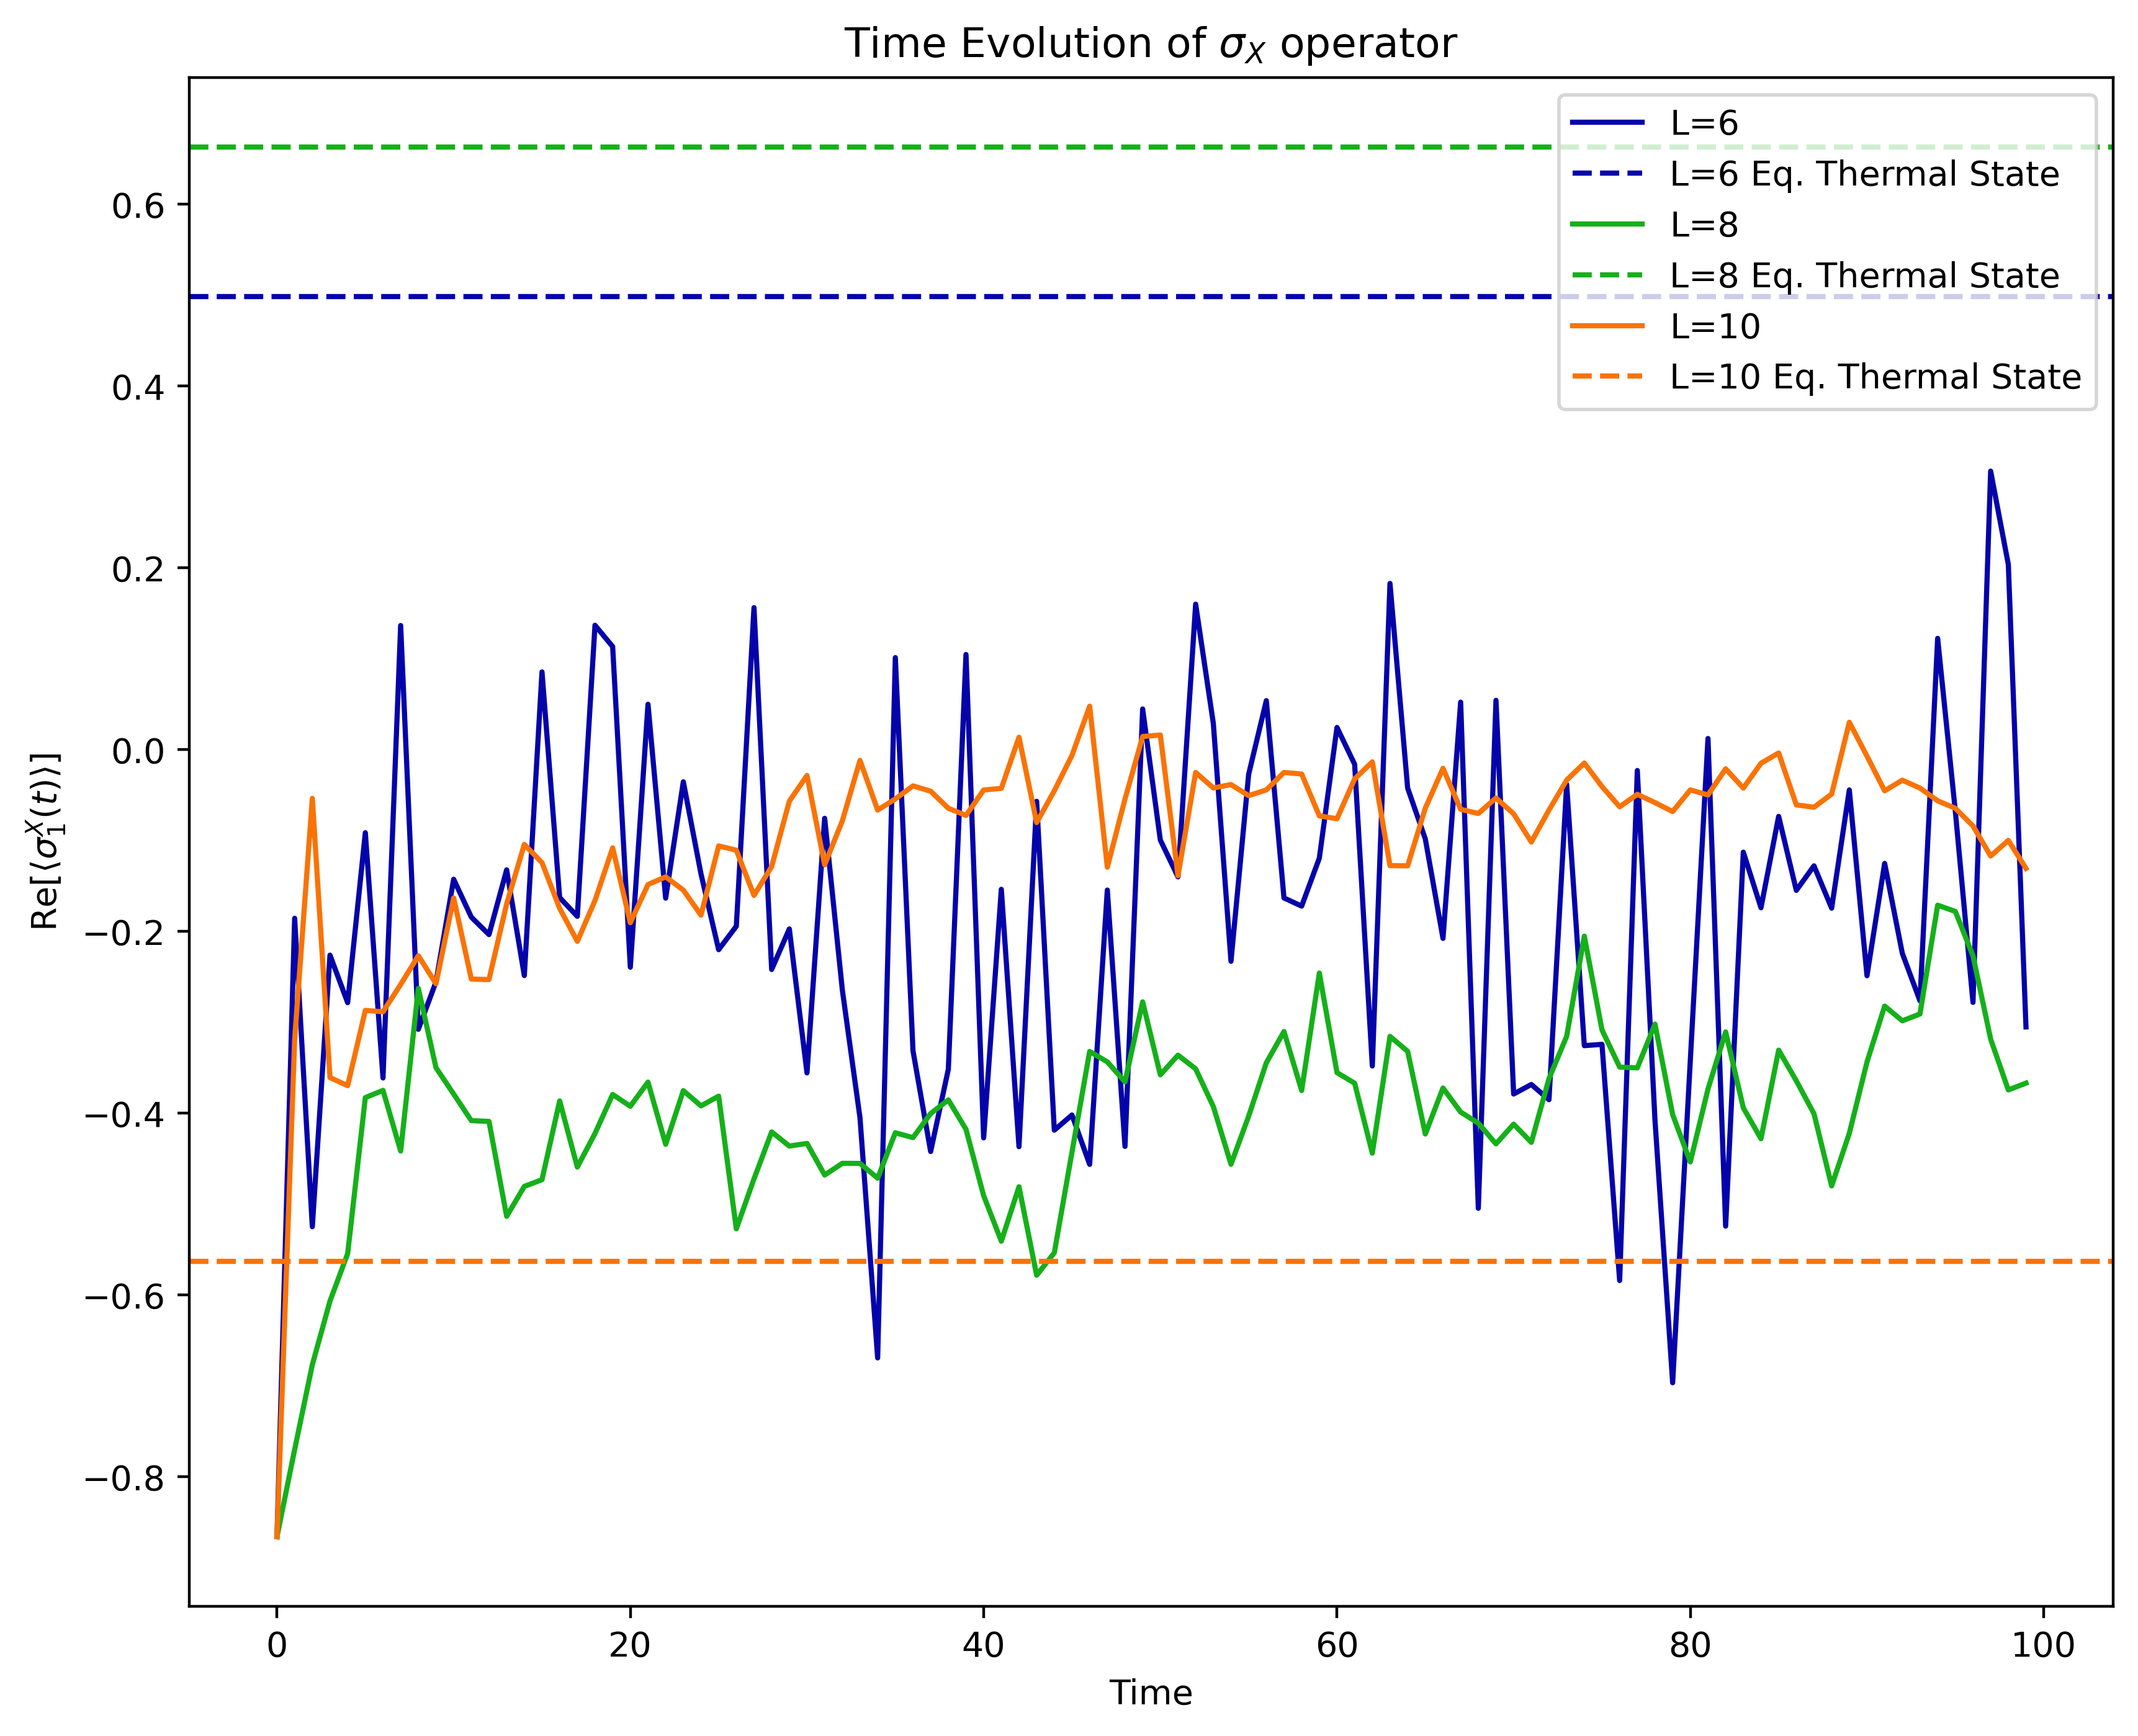

In [49]:
dt = 1
T = np.arange(0,1e2, dt)

plt.figure(figsize=(10, 8))



for i in range(len(Ls)-2):
    
    L = Ls[i]
    eigs, vecs = eigss[i], vecss[i]
    psi = psi_initial(L)
    coeffs = vecs.conj().T @ psi
    sigma_matrix = sigma('x', vecs)

    Yarray = []
    for t in tqdm(T, desc=f'Processing L={L}'):
        Yarray.append(expectation_value(sigma_matrix, eigs, coeffs, t))
        
    xkcd_colors=['xkcd:royal blue', 'xkcd:green', 'xkcd:orange', 'xkcd:hot pink']

    # Plot the time evolution
    plt.plot(T, Yarray, label=f'L={L}', color=xkcd_colors[i])
    plt.axhline(y=sigma_thermal('x', eigs, vecs, 0.374), color=xkcd_colors[i], linestyle='--', label=f'L={L} Eq. Thermal State')


plt.xlabel('Time')
plt.ylabel(r'Re[$\langle \sigma_1^X (t) \rangle$]')
plt.title(r'Time Evolution of $\sigma_X$ operator')
plt.legend()
plt.savefig(os.path.join(directory, 'sigmaxMBL.png'), dpi=400)
plt.show()
